# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png)

##  Project Capstone

### Reducing Electricity Costs in Romania: Predictive and Reinforcement Learning for Solar Battery Optimization

---

[README](../README.md) | [Part 1: Cleaning](01_Cleaning.ipynb) | [Part 2: EDA](02_EDA.ipynb) | [Part 3: Solar Energy Prediction Models](03_Model_Solar_Energy.ipynb) | [Part 4: Electricity Cost Prediction Models](04_Model_Electricity_Cost.ipynb) | [Part 5: Electricity Cost Prediction Using Time Series Models](05_Model_Electricity_Cost_ts.ipynb) | **Part 6: Solar Battery Optimization**

---

### Introduction
- A solar battery is a device that stores energy generated by solar panels for later use.
- **Charging** a solar battery involves storing excess energy generated by the solar panel. When a solar battery is charging, it is in a state of receiving energy and cannot simultaneously discharge or supply power to the system.
- **Discharging** occurs when the stored energy in the solar battery is used to supply power to the system. When a solar battery is discharging, it cannot simultaneously charge as it is in a state of providing energy.
- An optimization model using reinforcement learning will be designed to minimize electricity costs, considering the predicted solar power availability and electricity prices for each hour. The model will learn when to charge or discharge the solar battery based on the current state, optimizing the use of stored energy to ensure efficiency and cost-effectiveness.

### Assumption
- According to [Romania Total Energy Consumption](https://www.enerdata.net/estore/energy-market/romania/#:~:text=Romania%20Total%20Energy%20Consumption,again%20by%207.7%25%20in%202022.), the electricity consumption per capita is 2,300 kWh per year. Therefore, the average electricity usage per household of two people is approximately 13 kWh per day.
- According to [The Evolution of Romania's solar PV Market](https://rpia.ro/wp-content/uploads/2024/03/The-evolution-of-the-PV-market-in-Romania-in-2023.pdf?form=MG0AV3), as of 2023, the country has installed over 2.85 GW of solar capacity.
- According to [Romania's Rooftop Country Profile](https://caneurope.org/content/uploads/2024/04/Romania-Residental-Rooftop-Solar-Country-Profile.pdf?form=MG0AV3), households typically have solar panel sizes of 3 to 5 kW.

### Import

#### Essential Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import time
np.random.seed(42)

#### Import Data

In [2]:
df = pd.read_csv('../data/cleaned/electricity_romania.csv')       # Import
df['datetime'] = pd.to_datetime(df['datetime'])                   # Formatting `datetime`
df['month'] = df['datetime'].dt.month                             # Extract month
df['hour'] = df['datetime'].dt.hour                               # Extract hour
df['day'] = df['datetime'].dt.day                                 # Extract day

In [3]:
# Electricity Cost by Hour
env = pd.DataFrame(df['ckwh'].groupby(df['hour']).median())

### Reinforcement Learning
- Reinforcement Learning (RL) is a branch of machine learning where an **agent** learns to make decisions by interacting with an **environment** to maximize cumulative **rewards**.
- The agent observes the state of environment, takes actions, and receives feedback in the form of rewards. Overtime, the agent learns a **policy**, a mapping from states to actions, that maximizes the expected cumulative rewards.
- One of the foundational methods in reinforcement learning is **Q-learning**.
- Q-learning is a model-free, off-policy algorithm where the agent learns the value of taking specific action in a specific state, known as the **Q-value**.
- The Q-values are stored in a table, called the **Q-table**, which gets updated iteratively using the **Bellman equation**:

$$
Q(s,a) \leftarrow Q(s,a) + \alpha\left[r + \gamma \max_{a'}Q(s',a')-Q(s,a)\right]
$$

- Where:
  - $Q(s,a)$ is the Q-value of taking action $a$ in state $s$.
  - $\alpha$ is the learning rate.
  - $r$ is the immediate reward received after taking action $a$.
  - $\gamma$ is the discount factor, which determines the importance of future rewards.
  - $\max_{a'}Q(s',a')$ is the maximum Q-value for the next state $s'$.
- Through repeated interactions with the environment, the agent updates its Q-values and converges to an optimal policy, where it selects actions that lead to the highest cumulative rewards.

### Q-learning for Solar Battery Optimization

#### Fundamental Concept
- **Environment**
    - The electricity cost by hour is the median of the costs for each hour.
    - The solar energy collected by a household is calculated from the proportion of the median solar production (on a country scale) to the household scale.
    - The hourly load (hourly demand) is calculated based on the average usage per household, assumed to be 13 kWh per day. This demand is distributed according to three patterns: 1. Uniform, 2. Peak-hour usage, and 3. Non-peak hour usage.
      - Uniform: Energy usage is evenly distributed across all hours of the day.
      - Peak-hour usage: Energy usage is higher during peak hours, reflecting typical household consumption patterns.
      - Non-peak hour usage: Energy usage varies unpredictably and does not follow a consistent pattern.
- **Agent**
  - The agent interacts with the environment by making decisions to **Charge** or **Discharge** the solar battery.
  - The immediate reward for the agent is based on the electricity cost calculated according to its action.
- **State**
  - A state represents the current situation or condition of the agent within the environment.
  - The state is defined by the hour of the day and the battery level. To ensure the number of states is finite, the battery level is rounded down and up into discrete intervals, rather than using a float number.

#### Environment

In [4]:
# Solar Energy Collected by Hour

# Daily Solar Energy Collected by Romania
daily_solar_romania = df['solar'].groupby(df['hour']).median().sum()

# Proportion to Household Scale (Solar Panel of 5 kW)
daily_solar_household = daily_solar_romania / 2850 * 5

print(f'Household Daily Solar Energy Collected: {daily_solar_household:.2f} kW')

Household Daily Solar Energy Collected: 5.80 kW


In [5]:
env['solar'] = df['solar'].groupby(df['hour']).median() / daily_solar_romania * daily_solar_household

In [6]:
# Uniform
env['load_uniform'] = 13 / 24
# Peak Hour
env['load_peak'] = env['ckwh'] * (13 / env['ckwh'].sum())
# Non Peak Hour
env['load_non_peak'] = (1 / env['ckwh']) * (13 / (1 / env['ckwh']).sum())

In [7]:
env.sum()

ckwh             179.335000
solar              5.799123
load_uniform      13.000000
load_peak         13.000000
load_non_peak     13.000000
dtype: float64

In [8]:
env

,ckwh,solar,load_uniform,load_peak,load_non_peak
hour,,,,,
0,7.240,0.000000,0.541667,0.524828,0.540989
1,6.890,0.000000,0.541667,0.499456,0.568470
2,6.415,0.000000,0.541667,0.465024,0.610563
3,6.110,0.000000,0.541667,0.442914,0.641041
4,5.955,0.000000,0.541667,0.431678,0.657726
5,5.855,0.000000,0.541667,0.424429,0.668960
6,6.050,0.000000,0.541667,0.438565,0.647398
7,6.860,0.003509,0.541667,0.497282,0.570956
8,8.005,0.147368,0.541667,0.580283,0.489289


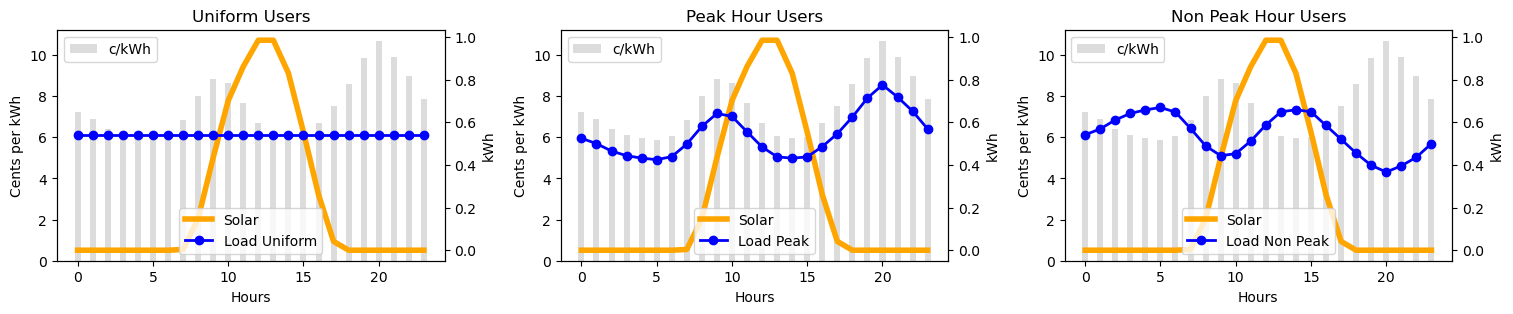

In [9]:
x = np.arange(24)

# Create 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 3), sharex=True, gridspec_kw={'hspace': 0.3, 'wspace': 0.3})

# --------------------------------------------------
ax1 = axes[0]
ax2 = ax1.twinx()  # Twin axis for the first subplot
ax1.bar(x
        , env['ckwh']
        , width = 0.4
        , color = 'gainsboro'
        , label = 'c/kWh'
       )
ax2.plot(x
         , env['solar']
         , color = 'orange'
         , label = 'Solar'
         , linewidth = 4
        )
ax2.plot(x
         , env['load_uniform']
         , color = 'blue'
         , marker = 'o'
         , label = 'Load Uniform'
         , linewidth = 2
        )

ax1.set_xlabel('Hours')
ax1.set_ylabel('Cents per kWh')
ax2.set_ylabel('kWh')

# Set title
ax1.set_title('Uniform Users')

# Legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='lower center')
# --------------------------------------------------

# --------------------------------------------------
ax3 = axes[1]
ax4 = ax3.twinx()  # Twin axis for the first subplot
ax3.bar(x
        , env['ckwh']
        , width = 0.4
        , color = 'gainsboro'
        , label = 'c/kWh'
       )
ax4.plot(x
         , env['solar']
         , color = 'orange'
         , label = 'Solar'
         , linewidth = 4
        )
ax4.plot(x
         , env['load_peak']
         , color = 'blue'
         , marker = 'o'
         , label = 'Load Peak'
         , linewidth = 2
        )

ax3.set_xlabel('Hours')
ax3.set_ylabel('Cents per kWh')
ax4.set_ylabel('kWh')

# Set title
ax3.set_title('Peak Hour Users')

# Legends for both axes
ax3.legend(loc='upper left')
ax4.legend(loc='lower center')
# --------------------------------------------------

# --------------------------------------------------
ax5 = axes[2]
ax6 = ax5.twinx()  # Twin axis for the first subplot
ax5.bar(x
        , env['ckwh']
        , width = 0.4
        , color = 'gainsboro'
        , label = 'c/kWh'
       )
ax6.plot(x
         , env['solar']
         , color = 'orange'
         , label = 'Solar'
         , linewidth = 4
        )
ax6.plot(x
         , env['load_non_peak']
         , color = 'blue'
         , marker = 'o'
         , label = 'Load Non Peak'
         , linewidth = 2
        )

ax5.set_xlabel('Hours')
ax5.set_ylabel('Cents per kWh')
ax6.set_ylabel('kWh')

# Set title
ax5.set_title('Non Peak Hour Users')

# Legends for both axes
ax5.legend(loc='upper left')
ax6.legend(loc='lower center')
# --------------------------------------------------

# Adjust the layout using subplots_adjust
plt.subplots_adjust(wspace = 0.5)

plt.savefig('../image/load_profile.png', dpi = 300, bbox_inches = 'tight')
plt.show();

#### Hyperparameter and Initial Variables

In [10]:
initial_reward = -3             # Initial reward value
alpha = 0.1                     # Learning rate
gamma = 0.99                    # Discount factor
min_epsilon = 0.01              # Minimum exploration rate
initial_epsilon = 1             # Initial exploration rate
decay_rate = 0.999              # Decay rate for epsilon
num_episodes = 10000            # Number of episodes

initial_battery = 3             # Initial battery level
max_battery = 100               # Maximum battery capacity

threshold = 0.001               # Threshold to check convergence of Q-table
threshold_limit = 9             # Threshold counter limit

#### Action System
- The epsilon greedy function is applied.
- If the random number is less than epsilon, the agent chooses to **explore** and selects a random action (either charge or discharge the battery).
- Otherwise, the agent chooses to **exploit** by selecting the best action based on the Q-values in the Q-Table.

In [11]:
# ε-greedy policy function
# 0 = Charge
# 1 = Discharge

def act(state, Q, epsilon, default_value = initial_reward):
    if state not in Q:
        Q[state] = {0: default_value, 1: default_value}           # Check if state exists in Q, if not, add it with default values
    if np.random.rand() < epsilon:
        return np.random.choice([0, 1])                           # Explore: choose a random action
    else:
        return max(Q[state], key = Q[state].get)                  # Exploit: choose best action based on Q-values

#### Reward System
- Charging: If the agent decides to charge the battery, the battery level increases according to the available solar energy at that moment. The reward for this action is calculated by multiplying the electricity cost per hour by the hourly load.
- Discharging: If the agent opts to discharge the battery, the battery level decreases by the hourly load, ensuring it doesn't drop below zero. The reward for this action is based on the electricity cost of the excess load (or 0 if there is none).

In [12]:
# Reward function
# The reward is equal to the electricity cost at each hour

def reward(state, battery_level, action):
    
    # Charge
    if action == 0:   
        rwd = -ckwh[state[0]] * ld[state[0]]
        next_battery_level = min(max_battery, battery_level + solar[state[0]])
        
    # Discharge    
    else:  
        if battery_level >= ld[state[0]]:
            rwd = 0
            next_battery_level = battery_level - ld[state[0]]
        else:
            rwd = -ckwh[state[0]] * (ld[state[0]] - battery_level)
            next_battery_level = 0
            
    next_state = (state[0] + 1, math.floor(next_battery_level), math.ceil(next_battery_level))
    return next_state, next_battery_level, rwd

#### Update Q-Table Function
- After each action, the agent receives an immediate reward, which is then used to update the Q-Table using the Bellman equation.
- The agent updates the Q-value for the current state-action pair to reflect the learned reward and future expected rewards.

In [13]:
# Update Q Table

def upd(state, action, next_state, rwd):
    # If it is not the end of the episode, update with the best next action
    if next_state[0] < 24:  
        
        if next_state not in Q:
            Q[next_state] = {0: initial_reward, 1: initial_reward}
            
        best_next_action = max(Q[next_state], key = Q[next_state].get)
        Q[state][action] += alpha * (rwd + gamma * Q[next_state][best_next_action] - Q[state][action])
   
    # Otherwise, use the immediate reward
    else:  
        Q[state][action] += alpha * (rwd - Q[state][action])

#### Training Loops
- At the beginning of each episode, reset the environment to its initial state (hour 0, initial battery level).
- The agent chooses an action using the epsilon-greedy strategy (explore or exploit to charge or discharge the battery).
- Execute the chosen action, obtain the reward, update the Q-table, and transition to the next state.
- The episode ends, storing the actions and rewards of each episode before beginning the next one.
- The epsilon decays in each episode to encourage the agent to exploit more as training progresses.
- Continue this process until the Q-table converges, i.e., when the values update within a non-significant threshold over time.

In [14]:
# Environment
ckwh = env['ckwh'].to_list()
solar = env['solar'].to_list()
ld = env['load_uniform'].to_list()

Q = {}
episode_actions = []
episode_rewards = []
episode_battery_lvs = []
threshold_counter = 0

start_time = time.time()

for episode in range(num_episodes):
    state = (0, initial_battery, initial_battery)
    battery_level = initial_battery
    epsilon = max(min_epsilon, initial_epsilon * (decay_rate ** episode))
    
    episode_action = []
    episode_reward = []
    episode_battery_lv = []
    
    Q_beg = sum([value for state_values in Q.values() for value in state_values.values()])
    
    while state[0] < 24:
        action = act(state, Q, epsilon)
        next_state, next_battery_level, rwd = reward(state, battery_level, action)
        
        episode_action.append((state[0], action))
        episode_battery_lv.append((state[0], next_battery_level))
        episode_reward.append((state[0], rwd))
        
        upd(state, action, next_state, rwd)
        
        upd_Q = {s: v.copy() for s, v in Q.items()}
        state = next_state
        battery_level = next_battery_level
        
    episode_actions.append(episode_action)
    episode_rewards.append(episode_reward)
    episode_battery_lvs.append(episode_battery_lv)
    
    Q_end = sum([value for state_values in Q.values() for value in state_values.values()])
    if abs(Q_beg - Q_end) < threshold:
        threshold_counter += 1
    if threshold_counter > threshold_limit:
        break

print(f'Training time: {time.time() - start_time:.2f} seconds.')
print(f'Q-table converges after {episode:,d} episodes.')
print(f'The best reward is {-max([sum(x[1] for x in episode_rewards[y]) for y in range(len(episode_rewards))]):.2f} cents.')

episode_actions_uniform = episode_actions
episode_rewards_uniform = episode_rewards
episode_battery_lvs_uniform = episode_battery_lvs
Q_uniform = Q

Training time: 3.54 seconds.
Q-table converges after 4,122 episodes.
The best reward is 35.46 cents.


In [15]:
# Environment
ckwh = env['ckwh'].to_list()
solar = env['solar'].to_list()
ld = env['load_peak'].to_list()

Q = {}
episode_actions = []
episode_rewards = []
episode_battery_lvs = []
threshold_counter = 0

start_time = time.time()

for episode in range(num_episodes):
    state = (0, initial_battery, initial_battery)
    battery_level = initial_battery
    epsilon = max(min_epsilon, initial_epsilon * (decay_rate ** episode))
    
    episode_action = []
    episode_reward = []
    episode_battery_lv = []
    
    Q_beg = sum([value for state_values in Q.values() for value in state_values.values()])
    
    while state[0] < 24:
        action = act(state, Q, epsilon)
        next_state, next_battery_level, rwd = reward(state, battery_level, action)
        
        episode_action.append((state[0], action))
        episode_battery_lv.append((state[0], next_battery_level))
        episode_reward.append((state[0], rwd))
        
        upd(state, action, next_state, rwd)
        
        upd_Q = {s: v.copy() for s, v in Q.items()}
        state = next_state
        battery_level = next_battery_level
        
    episode_actions.append(episode_action)
    episode_rewards.append(episode_reward)
    episode_battery_lvs.append(episode_battery_lv)
    
    Q_end = sum([value for state_values in Q.values() for value in state_values.values()])
    if abs(Q_beg - Q_end) < threshold:
        threshold_counter += 1
    if threshold_counter > threshold_limit:
        break

print(f'Training time: {time.time() - start_time:.2f} seconds.')
print(f'Q-table converges after {episode:,d} episodes.')
print(f'The best reward is {-max([sum(x[1] for x in episode_rewards[y]) for y in range(len(episode_rewards))]):.2f} cents.')

episode_actions_peak = episode_actions
episode_rewards_peak = episode_rewards
episode_battery_lvs_peak = episode_battery_lvs
Q_peak = Q

Training time: 3.79 seconds.
Q-table converges after 4,709 episodes.
The best reward is 34.13 cents.


In [16]:
# Environment
ckwh = env['ckwh'].to_list()
solar = env['solar'].to_list()
ld = env['load_non_peak'].to_list()

Q = {}
episode_actions = []
episode_rewards = []
episode_battery_lvs = []
threshold_counter = 0

start_time = time.time()

for episode in range(num_episodes):
    state = (0, initial_battery, initial_battery)
    battery_level = initial_battery
    epsilon = max(min_epsilon, initial_epsilon * (decay_rate ** episode))
    
    episode_action = []
    episode_reward = []
    episode_battery_lv = []
    
    Q_beg = sum([value for state_values in Q.values() for value in state_values.values()])
    
    while state[0] < 24:
        action = act(state, Q, epsilon)
        next_state, next_battery_level, rwd = reward(state, battery_level, action)
        
        episode_action.append((state[0], action))
        episode_battery_lv.append((state[0], next_battery_level))
        episode_reward.append((state[0], rwd))
        
        upd(state, action, next_state, rwd)
        
        upd_Q = {s: v.copy() for s, v in Q.items()}
        state = next_state
        battery_level = next_battery_level
        
    episode_actions.append(episode_action)
    episode_rewards.append(episode_reward)
    episode_battery_lvs.append(episode_battery_lv)
    
    Q_end = sum([value for state_values in Q.values() for value in state_values.values()])
    if abs(Q_beg - Q_end) < threshold:
        threshold_counter += 1
    if threshold_counter > threshold_limit:
        break

print(f'Training time: {time.time() - start_time:.2f} seconds.')
print(f'Q-table converges after {episode:,d} episodes.')
print(f'The best reward is {-max([sum(x[1] for x in episode_rewards[y]) for y in range(len(episode_rewards))]):.2f} cents.')

episode_actions_non_peak = episode_actions
episode_rewards_non_peak = episode_rewards
episode_battery_lvs_non_peak = episode_battery_lvs
Q_non_peak = Q

Training time: 2.74 seconds.
Q-table converges after 3,191 episodes.
The best reward is 37.32 cents.


#### Results

In [17]:
def avg_hour(data, n = 100, fst = True):
    if fst:  # Return the average of each hour from the first `n` elements of data
        return np.array([np.mean([lst[i][1] for lst in data[0:n]]) for i in range(24)])
    else:  # Return the average of each hour from the last `n` elements of data
        return np.array([np.mean([lst[i][1] for lst in data[-n:]]) for i in range(24)])

def acc_hour(data, n = 100, fst = True):
    cumulative_means = []
    
    # Get cumulative averages for the first `n` or last `n` elements
    avg_list = avg_hour(data, n, fst)
    
    # Iterate over the means (no hour tuple now)
    cumulative_sum = 0
    for mean_value in avg_list:
        cumulative_sum += mean_value
        cumulative_means.append(cumulative_sum)
    
    return np.array(cumulative_means)

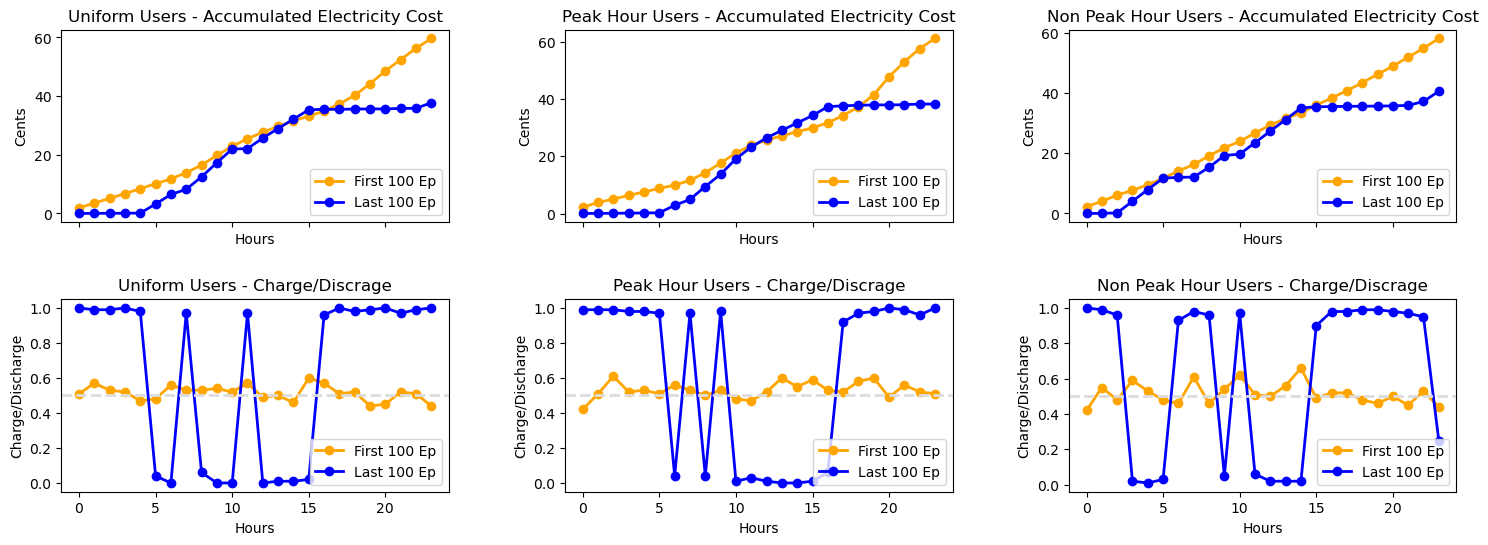

In [19]:
x = np.arange(24)
reward_first_100_uniform = acc_hour(episode_rewards_uniform, n = 100, fst = True) * -1
reward_last_100_uniform = acc_hour(episode_rewards_uniform, n = 100, fst = False) * -1

reward_first_100_peak = acc_hour(episode_rewards_peak, n = 100, fst = True) * -1
reward_last_100_peak = acc_hour(episode_rewards_peak, n = 100, fst = False) * -1

reward_first_100_non_peak = acc_hour(episode_rewards_non_peak, n = 100, fst = True) * -1
reward_last_100_non_peak = acc_hour(episode_rewards_non_peak, n = 100, fst = False) * -1

episode_actions_first_100_uniform = avg_hour(episode_actions_uniform, n = 100, fst = True)
episode_actions_last_100_uniform = avg_hour(episode_actions_uniform, n = 100, fst = False)

episode_actions_first_100_peak = avg_hour(episode_actions_peak, n = 100, fst = True)
episode_actions_last_100_peak = avg_hour(episode_actions_peak, n = 100, fst = False)

episode_actions_first_100_non_peak = avg_hour(episode_actions_non_peak, n = 100, fst = True)
episode_actions_last_100_non_peak = avg_hour(episode_actions_non_peak, n = 100, fst = False)



x = np.arange(24)

# Create 6 subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 6), sharex=True, gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

# --------------------------------------------------

ax1 = axes[0, 0]
ax1.plot(x, reward_first_100_uniform, color='orange', marker='o', label='First 100 Ep', linewidth=2)
ax1.plot(x, reward_last_100_uniform, color='blue', marker='o', label='Last 100 Ep', linewidth=2)
ax1.set_xlabel('Hours')
ax1.set_ylabel('Cents')
ax1.set_title('Uniform Users - Accumulated Electricity Cost')
ax1.legend(loc='lower right')


ax2 = axes[0, 1]
ax2.plot(x, reward_first_100_peak, color='orange', marker='o', label='First 100 Ep', linewidth=2)
ax2.plot(x, reward_last_100_peak, color='blue', marker='o', label='Last 100 Ep', linewidth=2)
ax2.set_xlabel('Hours')
ax2.set_ylabel('Cents')
ax2.set_title('Peak Hour Users - Accumulated Electricity Cost')
ax2.legend(loc='lower right')


ax3 = axes[0, 2]
ax3.plot(x, reward_first_100_non_peak, color='orange', marker='o', label='First 100 Ep', linewidth=2)
ax3.plot(x, reward_last_100_non_peak, color='blue', marker='o', label='Last 100 Ep', linewidth=2)
ax3.set_xlabel('Hours')
ax3.set_ylabel('Cents')
ax3.set_title('Non Peak Hour Users - Accumulated Electricity Cost')
ax3.legend(loc='lower right')

# --------------------------------------------------

ax4 = axes[1, 0]
ax4.plot(x, episode_actions_first_100_uniform, color='orange', marker='o', label='First 100 Ep', linewidth=2)
ax4.plot(x, episode_actions_last_100_uniform, color='blue', marker='o', label='Last 100 Ep', linewidth=2)
ax4.axhline(y = 0.5, color = 'gainsboro', linestyle='--', linewidth = 2)
ax4.set_xlabel('Hours')
ax4.set_ylabel('Charge/Discharge')
ax4.set_title('Uniform Users - Charge/Discrage')
ax4.legend(loc='lower right')


ax5 = axes[1, 1]
ax5.plot(x, episode_actions_first_100_peak, color='orange', marker='o', label='First 100 Ep', linewidth=2)
ax5.plot(x, episode_actions_last_100_peak, color='blue', marker='o', label='Last 100 Ep', linewidth=2)
ax5.axhline(y = 0.5, color = 'gainsboro', linestyle='--', linewidth = 2)
ax5.set_xlabel('Hours')
ax5.set_ylabel('Charge/Discharge')
ax5.set_title('Peak Hour Users - Charge/Discrage')
ax5.legend(loc='lower right')


ax6 = axes[1, 2]
ax6.plot(x, episode_actions_first_100_non_peak, color='orange', marker='o', label='First 100 Ep', linewidth=2)
ax6.plot(x, episode_actions_last_100_non_peak, color='blue', marker='o', label='Last 100 Ep', linewidth=2)
ax6.axhline(y = 0.5, color = 'gainsboro', linestyle='--', linewidth = 2)
ax6.set_xlabel('Hours')
ax6.set_ylabel('Charge/Discharge')
ax6.set_title('Non Peak Hour Users - Charge/Discrage')
ax6.legend(loc='lower right')




# Show the plot
plt.savefig('../image/final_result.png', dpi = 300, bbox_inches = 'tight')
plt.show()